Packages

In [2]:
from pyomo.environ import *
import numpy as np
import random
import pandas as pd
from numpy import flatnonzero as find
from pypower.api import case9, ext2int, bustypes, makeBdc, rundcpf, ppoption, case39, rundcopf
from pypower.idx_bus import BUS_TYPE, REF, VA, PD, LAM_P, LAM_Q, MU_VMAX, MU_VMIN
from pypower.idx_gen import PG, MU_PMAX, MU_PMIN, MU_QMAX, MU_QMIN, PMAX, PMIN, GEN_BUS
from pypower.idx_brch import PF, PT, QF, QT, RATE_A, MU_SF, MU_ST
from pypower.idx_cost import COST
import matplotlib.pyplot as plt

In [3]:
# Run PyPower case to get initial condition
ppc = case39()
ppopt = ppoption(VERBOSE=0)
pp_dcpf = rundcopf(ppc, ppopt)
pp_bus = pp_dcpf["bus"]
pp_branch = pp_dcpf["branch"]
pp_gen = pp_dcpf["gen"]


Converged in 0.04 seconds
Objective Function Value = 41263.94 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             39     Total Gen Capacity    7367.0           0.0 to 0.0
Generators        10     On-line Capacity      7367.0           0.0 to 0.0
Committed Gens    10     Generation (actual)   6254.2               0.0
Loads             21     Load                  6254.2               0.0
  Fixed           21       Fixed               6254.2               0.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          46     Losses (I^2 * Z)         0.00              0.00
Transformers      12     Branch Charging (inj)     -                0.0
Inter-ties         6     Total Inter-tie 

In [10]:
## convert to internal indexing
ppc = ext2int(ppc)
baseMVA, bus, gen, branch, gencost = \
    ppc["baseMVA"], ppc["bus"], ppc["gen"], ppc["branch"], ppc["gencost"]

## get bus index lists of each type of bus
ref, pv, pq = bustypes(bus, gen)
pvpq = np.matrix(np.r_[pv, pq])

## generator info
gbus = gen[:, GEN_BUS].astype(int)    ## what buses are they at?
refgen = find(gbus == ref)

## build B matrices and phase shift injections
B, Bf, _, _ = makeBdc(baseMVA, bus, branch)
B = B.todense()
Bf = Bf.todense()

# Problem dimensions
NG = gen.shape[0] # Number of generators
NB = bus.shape[0] # Number of buses
NBr = branch.shape[0] # Number of lines
NL = np.count_nonzero(pp_bus[:, PD]) # Number of loads
NW = 1 # Number of wind farms

# Map generator to bus
CG = np.zeros((NB,NG))
CG[gbus,range(NG)] = 1

# Map load to bus
CL = np.zeros((NB,NL))
load_bus = np.nonzero(pp_bus[:, PD])[0]
for i in range(len(load_bus)):
    CL[load_bus[i], i] = 1

# Map wind farm to bus
CW = np.zeros((NB,1))
CW[5,0] = 1

# Generator capacity limit p.u.
Pmax = gen[:, PMAX]/baseMVA
Pmin = gen[:, PMIN]/baseMVA

# Line flow limit p.u.
Lmax = branch[:, RATE_A]/baseMVA
Lmin = - branch[:, RATE_A]/baseMVA

# Quadratic cost coefficients
# Convert to p.u.
CG2 = gencost[:, COST]*baseMVA**2
CG1 = gencost[:, COST+1]*baseMVA
CG0 = gencost[:, COST+2]

# Cost coefficient for wind power
CW1 = 0
CW0 = 0

# Cost coefficients for generation reserve
CRG_up = 10*np.ones((NG,1))*baseMVA
CRG_down = 10*np.ones((NG,1))*baseMVA

# Cost coefficients for load reserve
CRL_up = 9.8*np.ones((NL,1))*baseMVA
CRL_down = 9.8*np.ones((NL,1))*baseMVA

# Uncontrollable load
load = pp_bus[:,PD]
PL_total = load[load > 0]
PL = PL_total/baseMVA

# Generator and demand set points
# Power in p.u., Va in rad
Pg0 = pp_gen[:, PG]/baseMVA
Pd0 = pp_bus[:, PD]/baseMVA
Pinj0 = (np.matmul(CG, Pg0) - Pd0)
Va0 = pp_bus[:, VA]/180*np.pi

In [5]:
# Read temperature data
weather_data = pd.read_csv("Weather_Data/NYC_Hourly_Normal_Temp.csv")
# Read wind power data
PW_data = pd.read_csv("spring_wind.csv",header=None).to_numpy()
PW_data = PW_data/500*20/baseMVA
# PW_data = PW_data[:, 0:4000]

In [7]:
Tamb = (weather_data.iloc[:,8] - 32)/1.8
Tamb_min = min(Tamb)
Tamb_10PCTL = (weather_data.iloc[:,6] - 32)/1.8
Tamb_90PCTL = (weather_data.iloc[:,7] - 32)/1.8
std_Tamb_10PCTL = (Tamb - Tamb_10PCTL)/1.282 
std_Tamb_90PCTL = (Tamb_90PCTL - Tamb)/1.282 
std_Tamb = (std_Tamb_10PCTL + std_Tamb_90PCTL)/10

In [19]:
def VS(dt,Tamb,num_TCL,Tset,delta,R,C,P_el,COP,baseMVA):
    Tdown = np.zeros(num_TCL)
    Tup = np.zeros(num_TCL)
    T_ON = np.zeros(num_TCL)
    T_OFF = np.zeros(num_TCL)
    D = np.zeros(num_TCL)
    B = 0
    Pdown = 0
    Pup = 0
    Sdown = 0
    Sup = 0
    for i in range(0,num_TCL):
        Tdown[i] = Tset[i] - delta/2
        Tup[i] = Tset[i] + delta/2
        T_ON[i] = C[i]*R[i]*np.log((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]))
        if ((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]) < 0):
            print(Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])
            print(Tup[i] - Tamb - R[i]*P_el[i]*COP[i])
        T_OFF[i] = C[i]*R[i]*np.log((Tup[i] - Tamb)/(Tdown[i] - Tamb))
        D[i] = T_ON[i]/(T_ON[i] + T_OFF[i])
        if ( Tamb < Tdown[i] and Tamb + R[i]*P_el[i]*COP[i] > Tup[i] ):
            B = B + P_el[i]*D[i]
            Pup = Pup + P_el[i]
            Sup = Sup + dt*P_el[i]*(1 - D[i])
    return [B/1000/baseMVA,Pdown/1000/baseMVA,Pup/1000/baseMVA,Sdown,Sup]

In [52]:
# Optimization: Problem formulation
def optimizer(NG,NL,Tamb_sample1,Tamb_sample2,PW_sample,num_TCL,Tset,delta,R,C,P_el,COP,S0,PL,\
    Pmax,Pmin,Lmax,Lmin,CG,CW,CL,CG0,CG1,CG2,CW0,CW1,CRG_up,CRG_down,CRL_up,CRL_down,nsample,PW_f):
    model = ConcreteModel()
    # Defining the variables
    model.PG = Var(range(NG),within = NonNegativeReals, initialize=0)
    model.PC = Var(range(NL),within = NonNegativeReals, initialize=0)
    model.RG_down = Var(range(NG),within = NonNegativeReals, initialize=0)
    model.RG_up = Var(range(NG),within = NonNegativeReals, initialize=0)
    model.RG = Var(range(NG),range(nsample),within = Reals, initialize=0)
    model.RL_down = Var(range(NL),within = NonNegativeReals, initialize=0)
    model.RL_up = Var(range(NL),within = NonNegativeReals, initialize=0)
    model.RL = Var(range(NL),range(nsample),within = Reals, initialize=0)
    model.dG_down = Var(range(NG),within = NonNegativeReals, initialize=0)
    model.dG_up = Var(range(NG),within = NonNegativeReals, initialize=0)
    model.dL_down = Var(range(NL),within = NonNegativeReals, initialize=0)
    model.dL_up = Var(range(NL),within = NonNegativeReals, initialize=0)
    model.Va = Var(range(NB), within=Reals, initialize=0, bounds=(-1,1))
    model.s1 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.s2 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.s3 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.s4 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.s5 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.s6 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    # model.s7 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    # model.s8 = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.d = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.e = Var(range(nsample), within=NonNegativeReals, initialize=0)
    model.dual = Suffix(direction=Suffix.IMPORT)

    ## Defining the deterministic constraints
    model.c = ConstraintList()

    # Power mismatch distribution
    model.c.add(sum(model.dG_down[i] for i in range(NG)) + sum(model.dL_up[j] for j in range(NL)) == 1)
    model.c.add(sum(model.dG_up[i] for i in range(NG)) + sum(model.dL_down[j] for j in range(NL)) == 1)
    
    # Line flow limit constraints
    for i in range(NBr):
        model.c.add(sum(Bf[i,j]*model.Va[j] for j in range(NB)) <= Lmax[i])
        model.c.add(sum(Bf[i,j]*model.Va[j] for j in range(NB)) >= Lmin[i])
    
    PB_all = np.zeros((NL,nsample))
    P_mis_wind_all = np.zeros(nsample)
    identified_VS_all = np.zeros((NL,nsample,5))
    
    # Defining the CC constraints
    for i in range(nsample):

        for j in range(NG):
        # Generation capacity limit
            model.c.add(model.PG[j] + model.RG[j,i] >= Pmin[j])
            model.c.add(model.PG[j] + model.RG[j,i] <= Pmax[j])
            # Reserve capacity limit
            model.c.add(model.RG[j,i] >= -model.RG_down[j])
            model.c.add(model.RG[j,i] <= model.RG_up[j])
    
        # DC Power flow constraint
        for j in range(NB):
            model.c.add(sum(CG[j,k]*model.PG[k] + CG[j,k]*model.RG[k,i] for k in range(NG)) + CW[j]*PW_sample[i]\
            - sum(CL[j,k]*PL[k] + CL[j,k]*model.PC[k] + CL[j,k]*model.RL[k,i] for k in range(NL)) >= sum(B[j,k]*model.Va[k] for k in range(NB)) - model.s1[i])
            model.c.add(sum(CG[j,k]*model.PG[k] + CG[j,k]*model.RG[k,i] for k in range(NG)) + CW[j]*PW_sample[i]\
            - sum(CL[j,k]*PL[k] + CL[j,k]*model.PC[k] + CL[j,k]*model.RL[k,i] for k in range(NL)) <= sum(B[j,k]*model.Va[k] for k in range(NB)) + model.s2[i])
            # model.c.add(sum(CG[j,k]*model.PG[k] + CG[j,k]*model.RG[k,i] for k in range(NG)) + CW[j]*PW_sample[i]\
            # - sum(CL[j,k]*PL[k] + CL[j,k]*model.PC[k] for k in range(NL)) >= sum(B[j,k]*model.Va[k] for k in range(NB)) - model.s1[i])
            # model.c.add(sum(CG[j,k]*model.PG[k] + CG[j,k]*model.RG[k,i] for k in range(NG)) + CW[j]*PW_sample[i]\
            # - sum(CL[j,k]*PL[k] + CL[j,k]*model.PC[k] for k in range(NL)) <= sum(B[j,k]*model.Va[k] for k in range(NB)) + model.s2[i])
        
        P_mis_wind = PW_sample[i] - PW_f
        P_mis_wind_all[i] = P_mis_wind

        PB = np.zeros(NL)

        # print(i)

        # P_mis_load = 0
        for j in range(NL):
            identified_VS = VS(0.25,Tamb_sample1[i],num_TCL[j],Tset[0:num_TCL[j],j],delta,R[0:num_TCL[j],j],C[0:num_TCL[j],j],P_el[0:num_TCL[j],j],COP[0:num_TCL[j],j],baseMVA)
            # print("VS0", j, identified_VS[0])
            identified_VS_all[j,i,:] = identified_VS
            PB[j] = identified_VS[0]
        
        PB_all[:,i] = PB
        
        model.c.add(model.e[i] >= P_mis_wind - sum(model.PC[j] for j in range(NL)) + sum(PB[j] for j in range(NL)))
        model.c.add(model.d[i] >= - P_mis_wind + sum(model.PC[j] for j in range(NL)) - sum(PB[j] for j in range(NL)))
        
        for j in range(NG):
            model.c.add(model.RG[j,i] == model.dG_up[j]*model.d[i] - model.dG_down[j]*model.e[i])
        

        for j in range(NL):
            model.c.add(model.RL[j,i] == model.dL_up[j]*model.e[i] - model.dL_down[j]*model.d[i])
            identified_VS1 = VS(0.25,Tamb_sample1[i],num_TCL[j],Tset[0:num_TCL[j],j],delta,R[0:num_TCL[j],j],C[0:num_TCL[j],j],P_el[0:num_TCL[j],j],COP[0:num_TCL[j],j],baseMVA)
            # identified_VS2 = VS(0.25,Tamb_sample2[i],num_TCL,Tset[:,j],delta,R[:,j],C[:,j],P_el[:,j],COP[:,j],baseMVA)

            model.c.add(model.PC[j] + model.RL[j,i] >= identified_VS1[1])
            model.c.add(model.PC[j] + model.RL[j,i] <= identified_VS1[2])
            model.c.add(model.RL[j,i] >= -model.RL_down[j])
            model.c.add(model.RL[j,i] <= model.RL_up[j])
            model.c.add(S0[j] + 0.25*(model.PC[j] + model.RL[j,i] - identified_VS1[0])*1000*baseMVA >= identified_VS1[3] - model.s3[i])
            model.c.add(S0[j] + 0.25*(model.PC[j] + model.RL[j,i] - identified_VS1[0])*1000*baseMVA  <= identified_VS1[4] + model.s4[i])
            model.c.add(S0[j] + 0.75*(model.PC[j] - identified_VS1[0])*1000*baseMVA  + 0.25*(model.PC[j] + model.RL[j,i]\
                 - identified_VS1[0])*1000*baseMVA  >= identified_VS1[3] - model.s5[i])
            model.c.add(S0[j] + 0.75*(model.PC[j] - identified_VS1[0])*1000*baseMVA  + 0.25*(model.PC[j] + model.RL[j,i]\
                 - identified_VS1[0])*1000*baseMVA  <= identified_VS1[4] + model.s6[i])

            # model.c.add(S0[j] + 0.75*(model.PC[j] - identified_VS2[0])*1000*baseMVA  + 0.25*(model.PC[j] + model.RL[j,i]\
            #      - identified_VS2[0])*1000*baseMVA  >= identified_VS2[3] - model.s7[i])
            # model.c.add(S0[j] + 0.75*(model.PC[j] - identified_VS2[0])*1000*baseMVA  + 0.25*(model.PC[j] + model.RL[j,i]\
            #      - identified_VS2[0])*1000*baseMVA  <= identified_VS2[4] + model.s8[i])
    
    def cost(model, CG0, CG1, CG2, CRG_down, CRG_up, nsample, CRL_down, CRL_up):

        cost = sum(CG0[i] for i in range(NG))\
                + sum(CG1[i]*model.PG[i] for i in range(NG))\
                + sum(CG2[i]*model.PG[i]**2 for i in range(NG))\
                + sum(CRG_up[i]*model.RG_up[i] for i in range(NG))\
                + sum(CRG_down[i]*model.RG_down[i] for i in range(NG))\
                + 1000*sum(model.s1[i] + model.s2[i] for i in range(nsample))\
                + 1e10*sum(model.s3[i] + model.s4[i] + model.s5[i] + model.s6[i] for i in range(nsample))\
                + 1000*sum(model.d[i] + model.e[i] for i in range(nsample))\
                + sum(CRL_up[i]*model.RL_up[i] for i in range(NL))\
                + sum(CRL_down[i]*model.RL_down[i] for i in range(NL))\
                # + 1e10*sum(model.s7[i] + model.s8[i] for i in range(nsample))\
                
                
        return cost

    model.obj = Objective(expr=cost(model, CG0, CG1, CG2, CRG_down, CRG_up, nsample, CRL_down, CRL_up), sense=minimize)

    
    return model, PB_all, P_mis_wind_all, identified_VS_all

In [53]:
# Parameters related to the demand side
num_TCL = np.zeros(NL)
for k in range(NL):
    num_TCL[k] = 50*np.ceil(PL[k]*baseMVA)

num_TCL = num_TCL.astype(int)

max_num_TCL = np.max(num_TCL).astype(int)

Tset = np.zeros((max_num_TCL, NL))
R = np.zeros((max_num_TCL, NL))
C = np.zeros((max_num_TCL, NL))
COP = np.zeros((max_num_TCL, NL))
P_el = np.zeros((max_num_TCL, NL))
Tset_set = [21,21.5,22,22.5,23]

for i in range(max_num_TCL): 
    for j in range(NL):
        s = random.sample(Tset_set,1)
        Tset[i,j] = s[0] 

delta = 1
R_nom = 2
R_low = 0.8*R_nom
R_high = 1.2*R_nom
C_nom = 2
C_low = 0.8*C_nom
C_high = 1.2*C_nom
COP_nom = 2.5
COP_low = 0.8*COP_nom
COP_high = 1.2*COP_nom

np.random.seed(0)

for i in range(NL): 
    R[:,i] = np.random.uniform(R_low,R_high,max_num_TCL)
    C[:,i] = np.random.uniform(C_low,C_high,max_num_TCL)
    COP[:,i] = np.random.uniform(COP_low,COP_high,max_num_TCL)
    for j in range(max_num_TCL):
        P_el[j,i] = np.ceil((Tset[j,i] + delta/2 - Tamb_min)/(R[j,i]*COP[j,i])) + 3
# Sampling
eps = 0.1
beta = 0.1
num_decision_variables = 5*NG + 5*NL
num_samples = np.ceil((2/eps)*(np.log(1/beta) + num_decision_variables)).astype(int)
num_samples2 = np.ceil((num_decision_variables + 1 + np.log(1/beta) + np.sqrt(2*(num_decision_variables+1)*np.log(1/beta)))/eps).astype(int)

# np.random.seed(1)
# Tamb_sample = np.random.normal(mu_Tamb,sigma_Tamb,num_samples)
# PW_sample = np.random.choice(PW_data[i,:], size=num_samples)

P_B = np.zeros((NL,1))
Pdown = np.zeros((NL,1))
Pup = np.zeros((NL,1))
Sdown = np.zeros((NL,1))
Sup = np.zeros((NL,1))
S0 = np.zeros((NL,1))

for j in range(NL):
    [P_B[j],Pdown[j],Pup[j],Sdown[j],Sup[j]] = \
        VS(0.25,Tamb[0],num_TCL[j],Tset[0:num_TCL[j],j],delta,R[0:num_TCL[j],j],C[0:num_TCL[j],j],P_el[0:num_TCL[j],j],COP[0:num_TCL[j],j],baseMVA)
    S0[j] = (Sdown[j] + Sup[j])/2    


In [46]:
print(num_samples)
print(num_samples2)

3147
1852


In [11]:
# Single period

# Define the model
# nsample= 50
# np.random.seed(1)
# Tamb_sample = np.random.normal(Tamb[0],std_Tamb[0],num_samples)
# PW_sample = np.random.choice(PW_data[0,:], size=num_samples)
# PW_f = np.median(PW_data[0,:])
# # PW_f = np.median(PW_data)
# model, PB_all, P_mis_wind, identified_VS_all = optimizer(NG,NL,
# Tamb_sample,PW_sample,num_TCL,Tset,delta,R,C,P_el,COP,S0,PL,\
#     Pmax,Pmin,Lmax,Lmin,CG,CW,CL,CG0,CG1,CG2,CW0,CW1,CRG_up,CRG_down,CRL_up,CRL_down,nsample,PW_f)

# # Solve the problem
# solver = SolverFactory("bonmin")
# solver.solve(model)

# model.display()

In [47]:
def cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL):
    r_pg = np.zeros(NG)
    r_rg_up = np.zeros(NG)
    r_rg_down = np.zeros(NG)
    r_rl_up = np.zeros(NL)
    r_rl_down = np.zeros(NL)
    r_pc = np.zeros(NL)
    gen_cost = np.zeros(NG)
    gen_r_cost = np.zeros(NG)
    load_r_cost = np.zeros(NL)


    for i in range(NG):
        r_pg[i] = model.PG[i]()
        r_rg_up[i] = model.RG_up[i]()
        r_rg_down[i] = model.RG_down[i]()
        gen_cost[i] = CG0[i] + CG1[i]*r_pg[i] + CG2[i]*r_pg[i]**2
        gen_r_cost[i] = CRG_up[i]*r_rg_up[i] + CRG_down[i]*r_rg_down[i]

    for i in range(NL):
        r_rl_up[i] = model.RL_up[i]()
        r_rl_down[i] = model.RL_down[i]()
        r_pc[i] = model.PC[i]()
        load_r_cost[i] = CRL_up[i]*r_rl_up[i] + CRL_down[i]*r_rl_down[i]

    total_cost = np.sum(gen_cost + gen_r_cost) + np.sum(load_r_cost)

    return r_pg,r_rg_up,r_rg_down,r_rl_up,r_rl_down,r_pc,gen_cost,gen_r_cost,load_r_cost,total_cost

In [59]:
# Multi-period 
import time

S0_all = np.zeros((24,NL))
R_PC = np.zeros((24,NL))
models = []
Tamb_samples1 = []
Tamb_samples2 = []
PW_samples = []
PW_fs = []
PB_alls = []
P_mis_wind_alls = []
identified_VS_alls = []
P_B_test = []
Pdown_test = []
Pup_test = []
Sdown_test = []
Sup_test = []

# Initialize at hour 0
for j in range(NL):
    [P_B[j],Pdown[j],Pup[j],Sdown[j],Sup[j]] = \
        VS(0.25,Tamb[0],num_TCL[j],Tset[0:num_TCL[j],j],delta,R[0:num_TCL[j],j],C[0:num_TCL[j],j],P_el[0:num_TCL[j],j],COP[0:num_TCL[j],j],baseMVA)
    S0_all[0,j] = (Sdown[j] + Sup[j])/2  

nsample= num_samples2

for h in range(1):

    print("Hour ", h)
    t_start = time.time()

    print("S0: ", S0_all[h])

    np.random.seed(1)
    Tamb_sample1 = np.random.normal(Tamb[h],std_Tamb[h],nsample)
    # Tamb_sample1 = Tamb[h]*np.ones(nsample)
    Tamb_sample2 = np.random.normal(Tamb[h+1],std_Tamb[h+1],nsample)
    PW_sample = np.random.choice(PW_data[h,:], size=nsample)
    PW_f = np.median(PW_data[h, :])
    # PW_sample = PW_f*np.ones(nsample)
    # PW_sample[PW_sample > 0.15] = 0.1
    # PW_f = np.median(PW_sample)
    

    # Define the problem
    model, PB_all, P_mis_wind_all, identified_VS_all = optimizer(NG,NL,Tamb_sample1,Tamb_sample2,PW_sample,num_TCL,Tset,delta,R,C,P_el,COP,S0_all[h,:],PL,\
        Pmax,Pmin,Lmax,Lmin,CG,CW,CL,CG0,CG1,CG2,CW0,CW1,CRG_up,CRG_down,CRL_up,CRL_down,nsample,PW_f)

    # print("S up: ", identified_VS_all[4])

    # Solve the problem
    solver = SolverFactory("bonmin")
    solver.solve(model)
    r_pg,r_rg_up,r_rg_down,r_rl_up,r_rl_down,r_pc,gen_cost,gen_r_cost,load_r_cost,total_cost = \
        cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL)
    R_PC[h,:] = r_pc

    models.append(model)
    Tamb_samples1.append(Tamb_sample1)
    # Tamb_samples2.append(Tamb_sample2)
    PW_samples.append(PW_sample)
    PW_fs.append(PW_f)
    PB_alls.append(PB_all)
    P_mis_wind_alls.append(P_mis_wind_all)
    identified_VS_alls.append(identified_VS_all)


    if h != 23:
        for j in range(NL):
            [P_B[j],Pdown[j],Pup[j],Sdown[j],Sup[j]] = \
                VS(0.25,Tamb[h],num_TCL[j],Tset[0:num_TCL[j],j],delta,R[0:num_TCL[j],j],C[0:num_TCL[j],j],P_el[0:num_TCL[j],j],COP[0:num_TCL[j],j],baseMVA)
            S0_all[h+1,j] = S0_all[h,j] + r_pc[j]*1000*baseMVA - P_B[j]*1000*baseMVA
        
            print("S up %d: %f" %(j, Sup[j]))
        
        P_B_test.append(P_B)
        Pdown_test.append(Pdown)
        Pup_test.append(Pup)
        Sdown_test.append(Sdown)
        Sup_test.append(Sup)

    t_end = time.time()
    print("Elapsed: ", t_end - t_start)


Hour  0
S0:  [ 2740.17592378  9004.33780394 13985.72339926  6541.16617128
 14570.98914206   194.89657375   251.06741718  8956.69074966
  9192.07127328  4417.32523328 19007.75919432  7662.18648358
  6927.94546277  8642.97288868  6285.32539786  3886.08585554
  7858.24186773  5754.1893975   7943.58220448   279.54496012
 30846.21386936]


KeyboardInterrupt: 

In [56]:
model.RL_down.pprint()
model.RL_up.pprint()

RL_down : Size=21, Index=RL_down_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :     0 :  0.05612059616433967 :  None : False : False : NonNegativeReals
      1 :     0 :  0.05612092352261699 :  None : False : False : NonNegativeReals
      2 :     0 : 0.056120406899985535 :  None : False : False : NonNegativeReals
      3 :     0 :  0.05612088279683863 :  None : False : False : NonNegativeReals
      4 :     0 :  0.05612087015496498 :  None : False : False : NonNegativeReals
      5 :     0 : 0.009834023800692683 :  None : False : False : NonNegativeReals
      6 :     0 : 0.014345052685871053 :  None : False : False : NonNegativeReals
      7 :     0 : 0.056128465199413696 :  None : False : False : NonNegativeReals
      8 :     0 :  0.05612441148291817 :  None : False : False : NonNegativeReals
      9 :     0 : 0.056121777307985905 :  None : False : False : NonNegativeReals
     10 :     0 :   0.0561244110355304 :  None : False : False : NonN

{'whiskers': [<matplotlib.lines.Line2D at 0x22eaa804790>,
 'caps': [<matplotlib.lines.Line2D at 0x22eaa804f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x22eaa8043a0>],
 'medians': [<matplotlib.lines.Line2D at 0x22eaa810340>],
 'fliers': [<matplotlib.lines.Line2D at 0x22eaa8106d0>],
 'means': []}

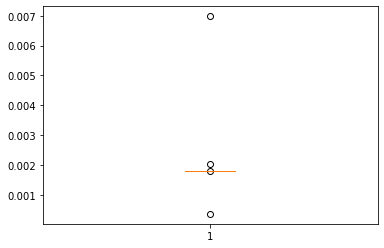

In [57]:
plt.boxplot(model.RL_up[:]())

In [121]:
import pickle

case_name = "case39"

# Write models
file = open("Results/models_%s_%d" %(case_name,nsample), "wb")
pickle.dump(models, file)
file.close()

# Write S0_all
file = open("Results/S0all_%s_%d" %(case_name,nsample),"wb")
pickle.dump(S0_all, file)
file.close()

# Write R_PC
file = open("Results/R_PC_%s_%d" %(case_name,nsample), "wb")
pickle.dump(R_PC, file)
file.close()

# Write Tamb_samples1
file = open("Results/Tamb_samples1_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Tamb_samples1, file)
file.close()

# Write Tamb_samples2
file = open("Results/Tamb_samples2_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Tamb_samples2, file)
file.close()

# Write PW_samples
file = open("Results/PW_samples_%s_%d" %(case_name,nsample), "wb")
pickle.dump(PW_sample, file)
file.close()

# Write PW_fs
file = open("Results/PW_fs_%s_%d" %(case_name,nsample), "wb")
pickle.dump(PW_fs, file)
file.close()

# Write PB
file = open("Results/PB_alls_%s_%d" %(case_name,nsample), "wb")
pickle.dump(PB_alls, file)
file.close()

# Write identified_VS_alls
file = open("Results/VS_alls_%s_%d" %(case_name,nsample), "wb")
pickle.dump(identified_VS_alls, file)
file.close()

# Write Pmis_winds
file = open("Results/P_mis_winds_%s_%d" %(case_name,nsample), "wb")
pickle.dump(P_mis_wind_alls, file)
file.close()

# Write P_B_test
file = open("Results/P_B_test_%s_%d" %(case_name,nsample), "wb")
pickle.dump(P_B_test, file)
file.close()

# Write Pup_test
file = open("Results/Pup_test_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Pup_test, file)
file.close()

# Write Pdown_test
file = open("Results/Pdown_test_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Pdown_test, file)
file.close()

# Write Sup_test
file = open("Results/Sup_test_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Sup_test, file)
file.close()

# Write Sdown_test
file = open("Results/Sdown_test_%s_%d" %(case_name,nsample), "wb")
pickle.dump(Sdown_test, file)
file.close()

In [53]:
PB_alls

[array([[0.17766255, 0.22591856, 0.22411478, 0.2358717 , 0.19404095,
         0.26238549, 0.17506276, 0.22914375, 0.20583177, 0.21809817,
         0.18116378, 0.25717575, 0.21967454, 0.22100469, 0.18824956,
         0.2364527 , 0.21643774, 0.23166113, 0.21180572, 0.2001394 ,
         0.23646841, 0.18801316, 0.1932601 , 0.20187275, 0.19327596,
         0.22747172, 0.2153687 , 0.23291088, 0.21849779, 0.2012715 ,
         0.22764292, 0.22127874, 0.22754606, 0.23095647, 0.22720236,
         0.21299001, 0.23682862, 0.20765796, 0.17689736, 0.19670319,
         0.21685656, 0.23187198, 0.22884057, 0.17619269, 0.21162026,
         0.22646323, 0.20859671, 0.16739182, 0.21012365, 0.1993973 ,
         0.20623896, 0.22031834, 0.23737261, 0.2202556 , 0.21722469,
         0.20005723, 0.1946112 , 0.19262323, 0.20655366, 0.19361509,
         0.22899681, 0.18567934, 0.20164755, 0.21914961, 0.20217436,
         0.21434756, 0.18829575, 0.17991838, 0.16555048, 0.24285362,
         0.24388124, 0.2236032 , 0

In [23]:
file = open("models0-8", "rb")
data = pickle.load(file)
file.close()
data

In [34]:
print("S0: \n", S0_all)
print("PC: \n", R_PC)

S0: 
 [[2800.33510499 2793.9095237  2794.65237511]
 [3376.11545659 3371.40270418 3374.34552024]
 [3775.45856233 3776.89597112 3781.94925479]
 [4002.56105385 4010.38939221 4017.46357665]
 [4057.42304069 4071.88296361 4080.88844849]
 [3997.45809307 4018.70994455 4029.58698886]
 [3880.07966583 3908.20361843 3920.92235004]
 [3762.70135698 3797.69729666 3812.25771024]
 [3702.73653725 3744.52428757 3760.95624829]
 [4044.66590167 4092.68424605 4111.19685005]
 [4845.90264694 4899.51033775 4920.34257991]
 [6278.68793863 6337.00311229 6360.483616  ]
 [8285.61009161 8347.83102991 8374.25853208]
 [8822.99628387 8889.24889591 8918.09507079]
 [9087.57965179 9133.2851038  9156.14114156]
 [9379.25808748 9392.06715001 9404.69161685]
 [9218.46859828 9198.79376222 9204.31362796]
 [8884.40001865 8866.35365875 8873.08086053]
 [   0.            0.            0.        ]
 [   0.            0.            0.        ]
 [   0.            0.            0.        ]
 [   0.            0.            0.        ]
 [  

In [1870]:
identified_VS = VS(0.25,-10,num_TCL,Tset[:,0],delta,R[:,0],C[:,0],P_el[:,0],COP[:,0],baseMVA)
identified_VS

[0.06557789654450581, 0.0, 0.08681, 0, 530.8025863873563]

In [1872]:
model.RG_up.pprint()
model.RG_down.pprint()
model.RL_up.pprint()
model.RL_down.pprint()

RG_up : Size=3, Index=RG_up_index
    Key : Lower : Value                  : Upper : Fixed : Stale : Domain
      0 :     0 :  1.379558389311056e-06 :  None : False : False : NonNegativeReals
      1 :     0 : 1.3795551434055288e-06 :  None : False : False : NonNegativeReals
      2 :     0 : 1.3795583325291806e-06 :  None : False : False : NonNegativeReals
RG_down : Size=3, Index=RG_down_index
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :     0 : 0.05780660536685922 :  None : False : False : NonNegativeReals
      1 :     0 : 0.05780660907041171 :  None : False : False : NonNegativeReals
      2 :     0 :  0.0578066044601672 :  None : False : False : NonNegativeReals
RL_up : Size=3, Index=RL_up_index
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :     0 : 0.0007051821532996659 :  None : False : False : NonNegativeReals
      1 :     0 : 1.976687702077583e-06 :  None : False : False : NonNegativeReals
      2 :     0

In [1873]:
max_d = 0
max_e = 0
for i in range(nsample):
    if max_d <= model.d[i]():
        max_d = model.d[i]()
    if max_e <= model.e[i]():
        max_e = model.e[i]()

print(max_d)
print(max_e)

0.0659238310219688
0.1749672158578191


In [1874]:
model.s3.pprint()
model.s4.pprint()
model.s5.pprint()
model.s6.pprint()

s3 : Size=50, Index=s3_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
      1 :     0 :   0.0 :  None : False : False : NonNegativeReals
      2 :     0 :   0.0 :  None : False : False : NonNegativeReals
      3 :     0 :   0.0 :  None : False : False : NonNegativeReals
      4 :     0 :   0.0 :  None : False : False : NonNegativeReals
      5 :     0 :   0.0 :  None : False : False : NonNegativeReals
      6 :     0 :   0.0 :  None : False : False : NonNegativeReals
      7 :     0 :   0.0 :  None : False : False : NonNegativeReals
      8 :     0 :   0.0 :  None : False : False : NonNegativeReals
      9 :     0 :   0.0 :  None : False : False : NonNegativeReals
     10 :     0 :   0.0 :  None : False : False : NonNegativeReals
     11 :     0 :   0.0 :  None : False : False : NonNegativeReals
     12 :     0 :   0.0 :  None : False : False : NonNegativeReals
     13 :     0 :   0.0 :  None : False : F

In [1875]:
total_RG_down = 0
total_RG_up = 0

for i in range(NG):
    total_RG_down += model.RG_down[i]()
    total_RG_up += model.RG_up[i]()

print(total_RG_down)
print(total_RG_up)

# total_RL_down = 0
# total_RL_up = 0

# for i in range(NL):
#     total_RL_down += model.RL_down[i]()
#     total_RL_up += model.RL_up[i]()

# print(total_RL_down)
# print(total_RL_up)

0.17341981889743813
4.1386718652457655e-06


In [1876]:
model.PC.pprint()

PC : Size=3, Index=PC_index
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :     0 : 0.04651441041440668 :  None : False : False : NonNegativeReals
      1 :     0 :  0.0469968134383421 :  None : False : False : NonNegativeReals
      2 :     0 : 0.04638701288333312 :  None : False : False : NonNegativeReals


In [1889]:
print("Pmax: ", Pmax)
print("Pg: ", r_pg)
print("RG_up: ", r_rg_up)
print("RG_down: ", r_rg_down)
print("RL_up: ", r_rl_up)
print("RL_down: ", r_rl_down)

Pmax:  [2.5 3.  2.7]
Pg:  [[0.86686091]
 [1.34533634]
 [0.94166855]]
RG_up:  [[1.37955839e-06]
 [1.37955514e-06]
 [1.37955833e-06]]
RG_down:  [[0.05780661]
 [0.05780661]
 [0.0578066 ]]
RL_up:  [[7.05182153e-04]
 [1.97668770e-06]
 [8.40488065e-04]]
RL_down:  [[0.02179309]
 [0.02251172]
 [0.02161913]]


In [1884]:
print(total_cost)
print(gen_cost)

5464.8728680346385
[[1410.02307099]
 [2299.88075122]
 [1515.42293942]]
